In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace, cauchy, multivariate_normal
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

from statsmodels.graphics.tsaplots import acf
import arviz as az

from utils import traceplot, acfplot

In [2]:
import wesanderson as wes

sns.set_palette(sns.color_palette(wes.film_palette('Darjeeling Limited')))

# Log Distributions


In [3]:
def logpi_normal(x, location=0, scale=1):
    return np.sum(norm.logpdf(x, loc=location, scale=scale))

def logpi_laplace(x, location=0, scale=1):
    return np.sum(laplace.logpdf(x, loc=location, scale=scale))

def logpi_cauchy(x, location=0, scale=1):
    return np.sum(cauchy.logpdf(x, loc=location, scale=scale))

def logpi_mvnormal(x, location=0, covariance=1):
    return np.sum(multivariate_normal.logpdf(x, mean=location, cov=covariance))

In [4]:
def grad_logpi_normal(x, location=0, scale=1):
    return - (x - location) /scale**2


def grad_logpi_laplace(x, location=0, scale=1):
    return - np.sign(x - location) / scale


def grad_logpi_cauchy(x, location=0, scale=1):
    return - 2*(x - location) / (scale**2 + (x - location)**2)


def grad_logpi_mvnormal(x, location=np.array([0, 0]), covariance=np.array([[1, 0], [0, 1]])):
    return - np.linalg.inv(covariance) @ (x - location)

# MCMC Algorithms


## Random Walk Metropolis


In [5]:
def random_walk_proposal(x, step_size):
    return x + step_size * np.random.normal(size=len(x))


def random_walk(logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Propose a candidate move
        y = random_walk_proposal(x, step_size)
        logpi_y = logpi(y, **kwargs)

        # Calculate the difference in the log-probabilities of the proposed and
        # current states (i.e. \log \frac{\pi(y)}{\pi(x)})
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store the current state
        x_samples[:, i] = x

    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

## Pre-conditioned Random Walk Metropolis


In [6]:
def preconditioned_random_walk_proposal(x, L, step_size):
    return x + step_size * L @ np.random.normal(size=len(x))


def preconditioned_random_walk(logpi, n_iter, x_init, location, covariance, step_size=1):
    x = np.asarray(x_init)
    location = np.asarray(location)
    covariance = np.asarray(covariance)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, location, covariance)

    # Preconditioning matrix: Cholesky factor
    L = np.linalg.cholesky(covariance)

    for i in range(n_iter):
        # Generate a proposal state
        y = preconditioned_random_walk_proposal(x, L, step_size)
        logpi_y = logpi(y, location, covariance)

        # Calculate log acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x

    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

## Barker Metropolis-Hastings


In [7]:
def barker_proposal(x, grad_logpi_x, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * grad_logpi_x))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y):
    z = y - x

    logq_xy = - np.log1p(np.exp(- z * grad_logpi_x))
    logq_yx = - np.log1p(np.exp(z * grad_logpi_y))

    return np.sum(logq_yx - logq_xy)
   

def barker(logpi, grad_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, **kwargs)

        # Generate a proposal state
        y = barker_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi(y, **kwargs)
        grad_logpi_y = grad_logpi(y, **kwargs)

        # Calculate log Barker acceptance rate
        logq_ratio = barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

## Pre-conditioned Barker Metropolis-Hastings


In [8]:
def preconditioned_barker_proposal(x, grad_logpi_x, L, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * (grad_logpi_x @ L)))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 
    z *= b

    return x + L @ z


def preconditioned_barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, L):
    z = np.linalg.inv(L) @ (y - x)

    logq_xy = - np.log1p(np.exp(- z * (grad_logpi_x @ L)))
    logq_yx = - np.log1p(np.exp(z * (grad_logpi_y @ L)))

    return np.sum(logq_yx - logq_xy)


def preconditioned_barker(logpi, grad_logpi, n_iter, x_init, location, covariance, step_size=1):
    x = np.asarray(x_init)
    location = np.asarray(location)
    covariance = np.asarray(covariance)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, location, covariance)

    # Preconditioning matrix: Cholesky factor
    L = np.linalg.cholesky(covariance)
    
    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, location, covariance)

        # Generate a proposal state
        y = preconditioned_barker_proposal(x, grad_logpi_x, L, step_size)
        logpi_y = logpi(y, location, covariance)
        grad_logpi_y = grad_logpi(y, location, covariance)

        # Calculate log preconditioned Barker acceptance rate
        logq_ratio = preconditioned_barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, L)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

## Metropolis-Adjusted Langevin Algorithm


In [9]:
def mala_proposal(x, grad_logpi_x, step_size):
    z = step_size * np.random.normal(size=len(x))

    return x + (step_size**2 /2) * grad_logpi_x + z


def mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * grad_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * grad_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def mala(logpi, grad_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, **kwargs)
        
        # Generate a proposal state
        y = mala_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi(y, **kwargs)
        grad_logpi_y = grad_logpi(y, **kwargs)

        # Calculate log MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

## Pre-conditioned Metropolis-Adjusted Langevin Algorithm


In [10]:
def preconditioned_mala_proposal(x, grad_logpi_x, L, step_size):
    z = step_size * np.random.normal(size=len(x))

    return x + (step_size**2 / 2) * (L @ L.T @ grad_logpi_x)+ L @ z


def preconditioned_mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, L, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (step_size**2 / 2) * (L @ L.T @ grad_logpi_x)), cov=(step_size**2 * (L @ L.T)))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (step_size**2 / 2) * (L @ L.T @ grad_logpi_y)), cov=(step_size**2 * (L @ L.T)))
    
    return log_yx - log_xy


def preconditioned_mala(logpi, grad_logpi, n_iter, x_init, location, covariance, step_size=1):
    x = np.asarray(x_init)
    location = np.asarray(location)
    covariance = np.asarray(covariance)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, location, covariance)

    # Preconditioning matrix: Cholesky factor
    L = np.linalg.cholesky(covariance)

    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, location, covariance)
        
        # Generate a proposal state
        y = preconditioned_mala_proposal(x, grad_logpi_x, L, step_size)
        logpi_y = logpi(y, location, covariance)
        grad_logpi_y = grad_logpi(y, location, covariance)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + preconditioned_mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, L, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

# Experiments


In [11]:
def ess(samples):
    output = []

    for chain in samples:
        output.append(az.ess(chain))

    return output


def compare_quantiles(samples):
    quantiles = pd.DataFrame(columns=['0.25', '0.5', '0.75'])
    quantiles.loc['Actual 1'] = norm.ppf([0.25, 0.5, 0.75], loc=0, scale=1)
    quantiles.loc[f'X_{1}'] = np.quantile(samples[0, :], [0.25, 0.5, 0.75])
    quantiles.loc['Actual 2'] = norm.ppf([0.25, 0.5, 0.75], loc=0, scale=np.sqrt(50))
    quantiles.loc[f'X_{2}'] = np.quantile(samples[1, :], [0.25, 0.5, 0.75])

    return quantiles

Acceptance rate:0.7066


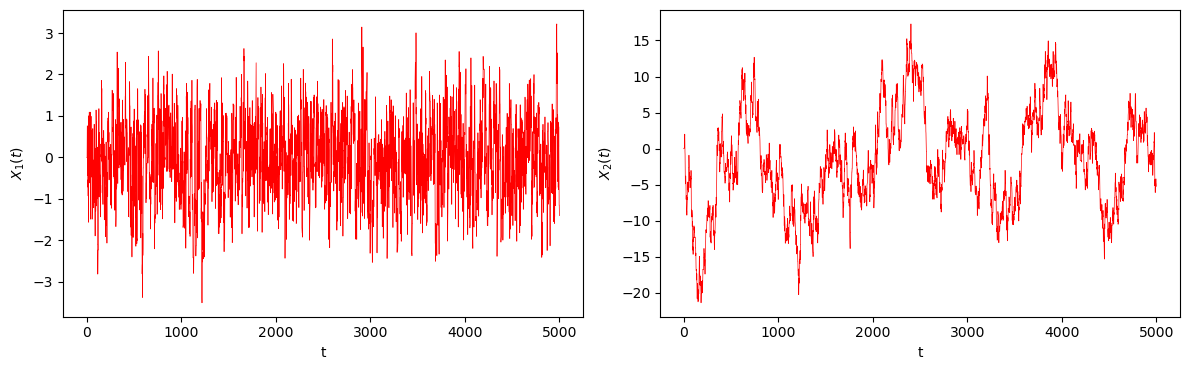

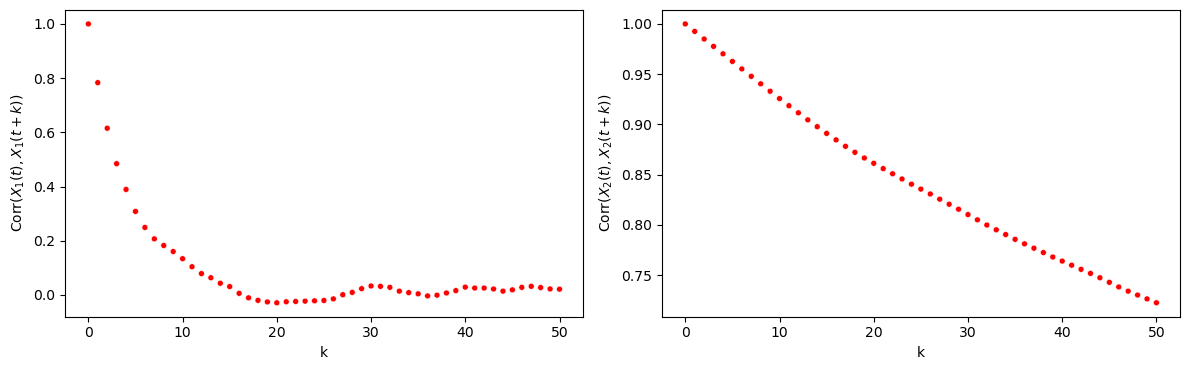

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.697525,-0.020869,0.606604
Actual 2,-4.769363,0.000000,4.769363
X_2,-6.333987,-1.759471,2.714518


In [12]:
samples, accept_rate = random_walk(
    logpi=logpi_mvnormal, 
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

Acceptance rate:0.5626


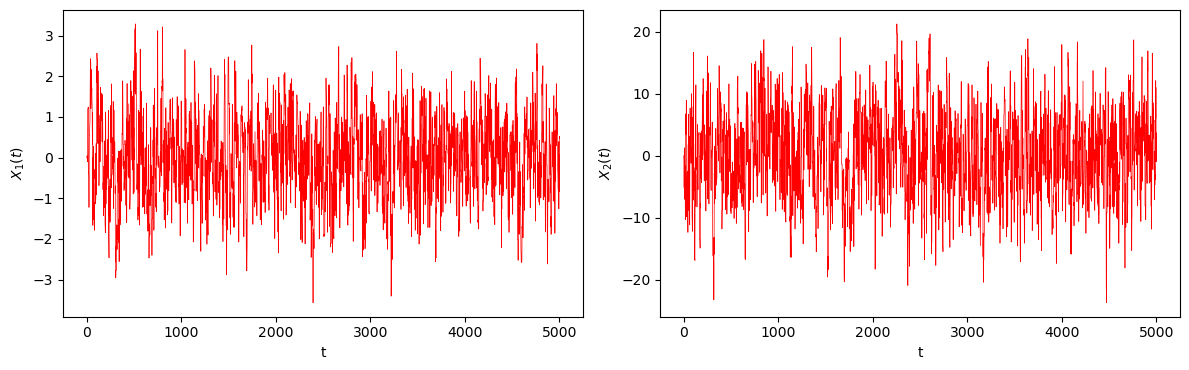

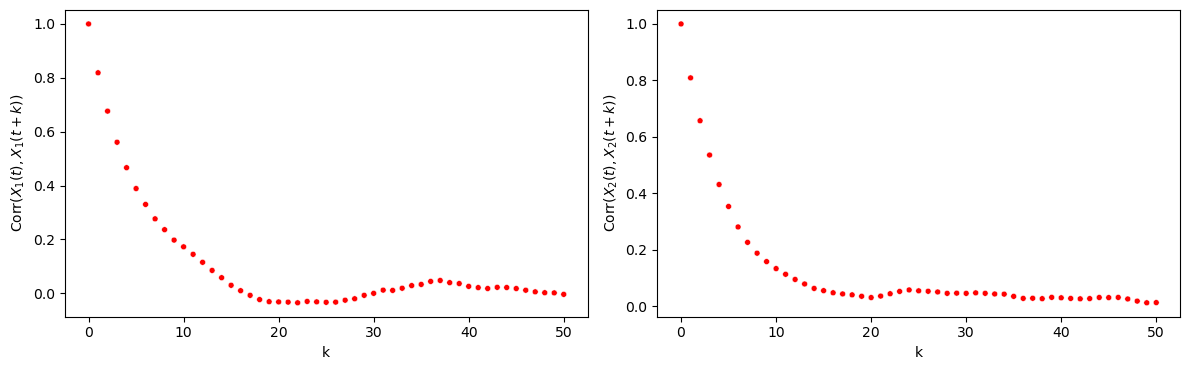

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.673858,-0.010873,0.660318
Actual 2,-4.769363,0.000000,4.769363
X_2,-4.558509,0.523627,5.336357


In [13]:
samples, accept_rate = preconditioned_random_walk(
    logpi=logpi_mvnormal, 
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

Acceptance rate:0.9164


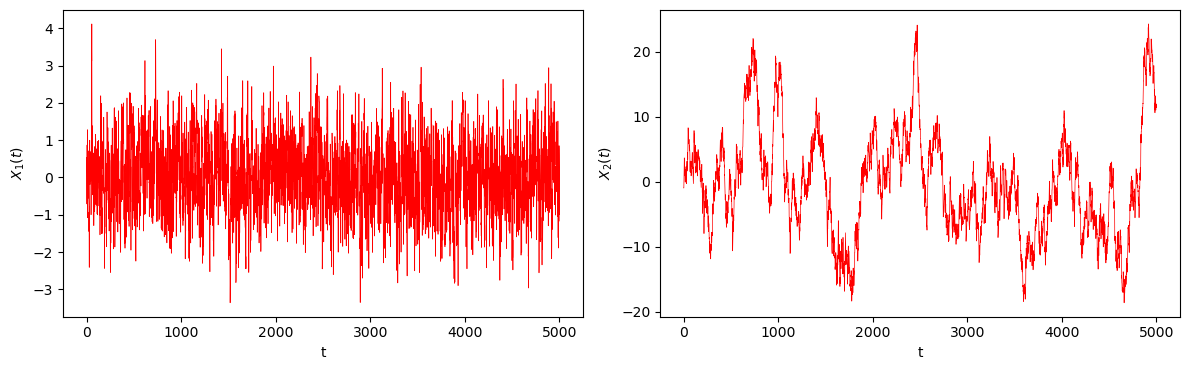

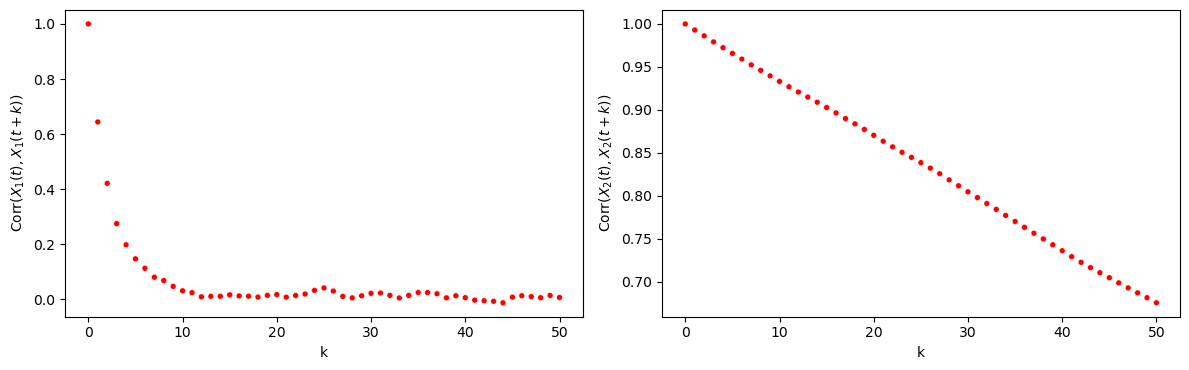

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.676352,0.022612,0.672349
Actual 2,-4.769363,0.000000,4.769363
X_2,-5.821191,-0.613443,4.194805


In [14]:
samples, accept_rate = barker(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal,
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

Acceptance rate:0.8546


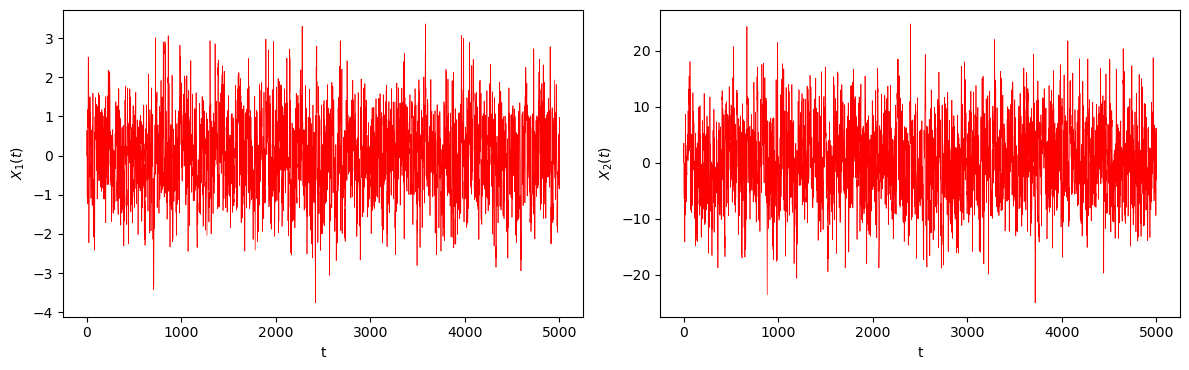

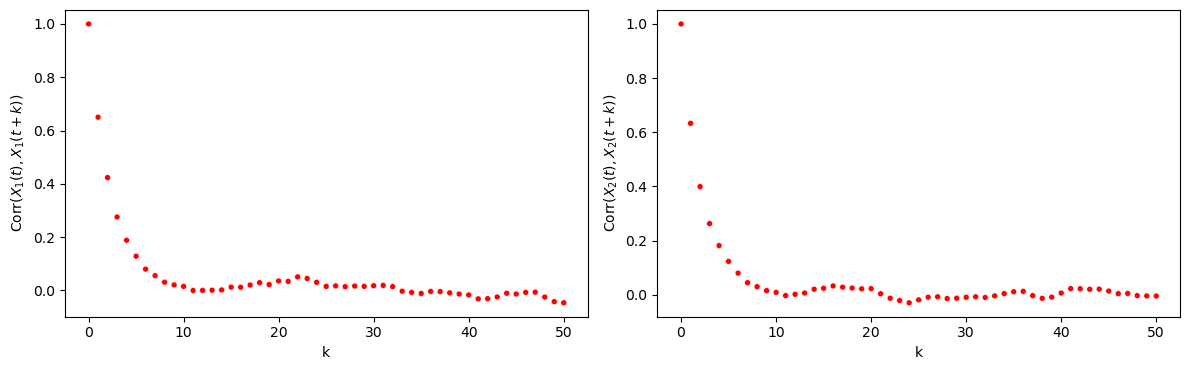

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.652187,0.015545,0.696580
Actual 2,-4.769363,0.000000,4.769363
X_2,-4.635601,0.013762,4.769577


In [15]:
samples, accept_rate = preconditioned_barker(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal,
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

Acceptance rate:0.348


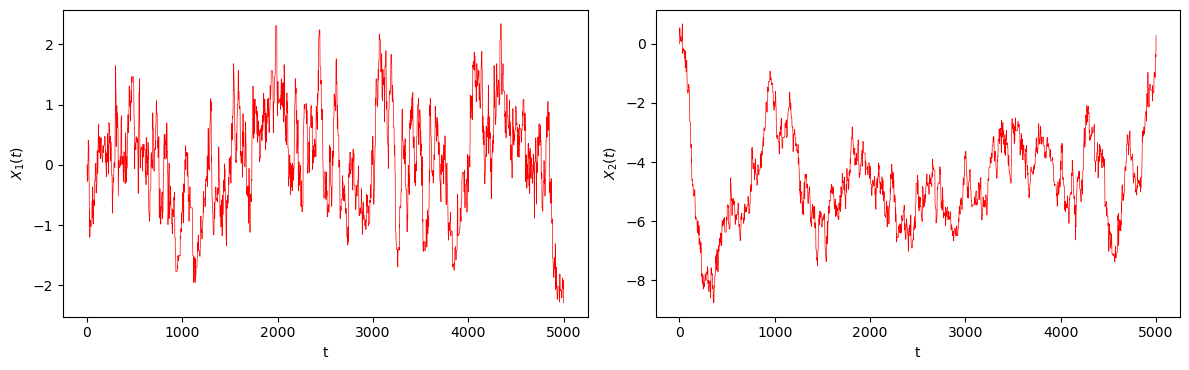

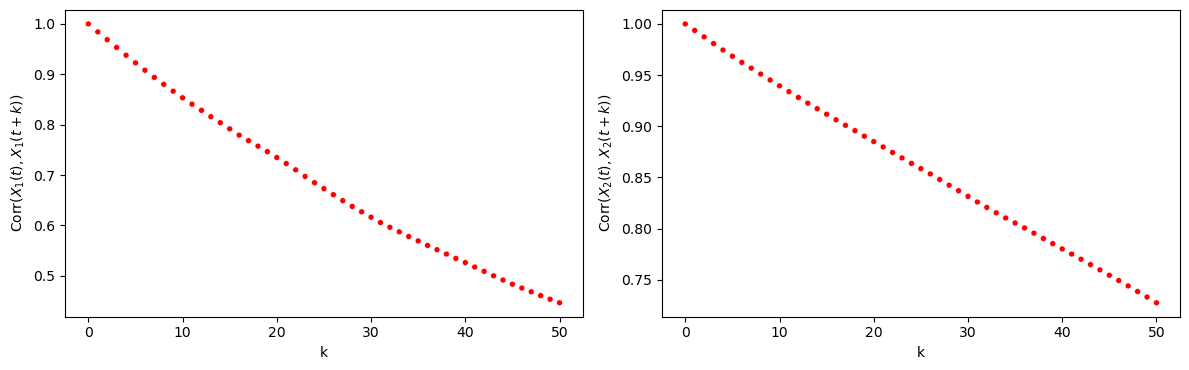

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.545142,0.111016,0.692888
Actual 2,-4.769363,0.000000,4.769363
X_2,-5.663946,-4.730327,-3.631641


In [16]:
samples, accept_rate = mala(
    logpi=logpi_mvnormal, 
    grad_logpi=logpi_mvnormal,
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]],
    step_size=0.3
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

Acceptance rate:0.8758


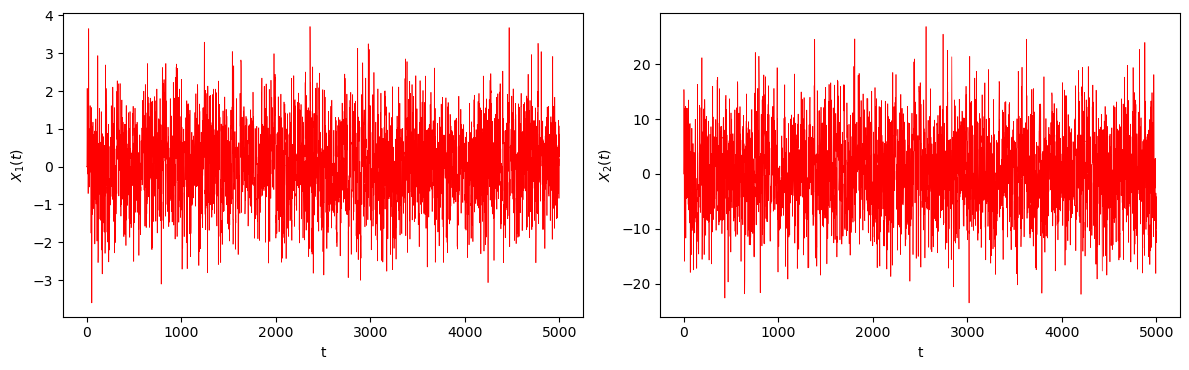

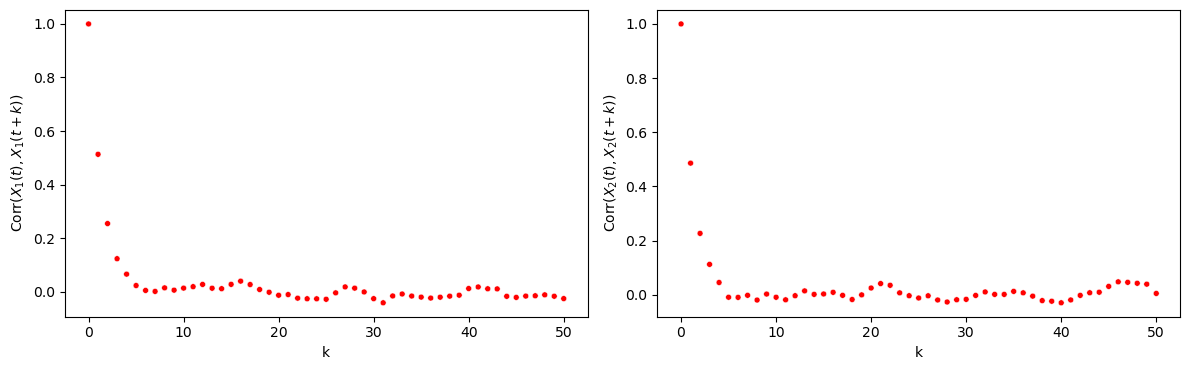

,0.25,0.5,0.75
Actual 1,-0.674490,0.000000,0.674490
X_1,-0.644230,0.032585,0.694137
Actual 2,-4.769363,0.000000,4.769363
X_2,-4.484677,0.183881,4.802598


In [17]:
samples, accept_rate = preconditioned_mala(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal,
    n_iter=5000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)
acfplot(samples, overlay=False)
compare_quantiles(samples)

RMW - 0.234
MALA Barker - 0.57
